In [208]:
%matplotlib inline

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot

# Experiment results

In [59]:
#Get data (previously cleaned in Cleaning.R)
data = pd.read_csv("all_data.csv")

In [60]:
data['sps'] = data.Session.astype(str).str.cat(data.Period.astype(str).str.cat(data.Subject.astype(str), sep='-'), sep='-')
#data.index = [data["Session"].map(str) + "-"+ data["Period"].map(str) + "-" + data["Subject"].map(str)]

In [61]:
data = data.set_index(data.sps,drop=True)

In [62]:
data.describe()

,Unnamed: 0,Period,Subject,MyPartner,Agent,Theta,Applet,Inv,Disclose,ProbType,ProbBarrel,Outcome,Retain,myRetention,Session,Treatment
count,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,1679.000000,1679.000000,1679.000000,1679.000000,3358.000000,3358.000000,1679.000000,1679.000000,3358.000000,3358.000000,3358.000000
mean,1679.500000,10.214413,11.672722,11.672722,0.500000,0.502680,0.284693,0.767719,0.458606,0.239279,0.148511,1.796307,0.445503,0.222752,4.483621,0.749851
std,969.515429,5.662160,6.721387,6.721387,0.500074,0.500142,0.451403,0.422413,0.498432,0.298357,0.162703,0.853492,0.497169,0.416155,2.154765,0.688186
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,840.250000,5.000000,6.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000
50%,1679.500000,10.000000,11.000000,11.000000,0.500000,1.000000,0.000000,1.000000,0.000000,0.050000,0.100000,2.000000,0.000000,0.000000,4.000000,1.000000
75%,2518.750000,15.000000,17.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.400000,0.300000,3.000000,1.000000,0.000000,6.000000,1.000000
max,3358.000000,20.000000,26.000000,26.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,0.400000,3.000000,1.000000,1.000000,8.000000,2.000000


In [65]:
#Here we have 1,320 observations of 'Decision' treatment, 1,558 of strat_lc, and 48 of strat_hc
data.Treatment.value_counts()

1    1558
0    1320
2     480
Name: Treatment, dtype: int64

## Are subjects being strategic in their retention decisions?

In [108]:
#How many periods are we taking into account?
per = 5

In [114]:
#When treatment is strategic:
#If I invest high and get zero I should kick out (so theory predicts zero):
Hi_sT_exp = data.Retain[((data.Inv==1) & (data.Outcome==3) & (data.Treatment!=0) & (data.Period>per))].mean()
Hi_sT_th = 0
#If I invest low and get zero I should retain (so close to one):
Li_sT_exp = data.Retain[((data.Inv==0) & (data.Outcome==3) & (data.Treatment!=0) & (data.Period>per))].mean()
Li_sT_th = 1
#When treatment is not strategic:
#If I invest high and get zero I should retain (close to one):
Hi_dT_exp = data.Retain[((data.Inv==1) & (data.Outcome==3) & (data.Treatment==0) & (data.Period>per))].mean()
Hi_dT_th = 1
#If I invest low and get zero I should retain (so close to one):
Li_dT_exp = data.Retain[((data.Inv==0) & (data.Outcome==3) & (data.Treatment==0) & (data.Period>per))].mean()
Li_dT_th = 1

In [117]:
ret_table = pd.DataFrame([[Hi_sT_exp,Li_sT_exp,Hi_sT_exp-Li_sT_exp,Hi_dT_exp,Li_dT_exp,Hi_dT_exp-Li_dT_exp],\
             [Hi_sT_th,Li_sT_th,Hi_sT_th-Li_sT_th,Hi_dT_th,Li_dT_th,Hi_dT_th-Li_dT_th]],index=['Data','Theory'])
cols = ['HighI,Strategic','LowI,Strategic','Diff','HighI,Decision','LowI,Decision','Diff']
ret_table.columns = cols

In [118]:
ret_table

,"HighI,Strategic","LowI,Strategic",Diff,"HighI,Decision","LowI,Decision",Diff
Data,0.189189,0.488636,-0.299447,0.738095,0.846154,-0.108059
Theory,0.000000,1.000000,-1.000000,1.000000,1.000000,0.000000


In [105]:
data.Retain[((data.Inv==1) & (data.Outcome==3) & (data.Treatment!=0))].std()

0.42941130806121736

## Are subjects understanding dominant disclosure strategies?

In [122]:
Ga_gb = data.Disclose[( (data.Theta==1) & (data.Applet==1))].mean()
Ba_gb = data.Disclose[( (data.Theta==1) & (data.Applet==0))].mean()
Ba_bb = data.Disclose[( (data.Theta==0) & (data.Applet==0))].mean()
print(Ga_gb,Ba_gb,Ba_bb)

0.777027027027 0.3475 0.325842696629


In [125]:
#This one is not dominant, it is mismatched: high investment low disclosure, low investment high disclosure
Ga_bb = data.Disclose[( (data.Theta==0) & (data.Applet==1) & (data.Inv==0))].mean()

In [145]:
data.Disclose.loc[data.SPSubj=='3-1-6']

sps
3-1-6    2.0
Name: Disclose, dtype: float64

In [135]:
data.SPSubj[5]

'3-1-6'

In [216]:
interactionsM = ['Treatment','Outcome','Inv','Period']
df = data[['Retain','Treatment','Outcome','Inv','Period']].dropna(axis=0)
df = df.reset_index()
df = df.drop('sps', 1)
y = df['Retain']
X = pd.DataFrame(df,columns=interactionsM)

In [218]:
mod = smf.ols(formula='Retain ~ C(Treatment) : C(Outcome) : Inv + Period:C(Outcome)', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Retain   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     11.28
Date:                Thu, 12 Jan 2017   Prob (F-statistic):           4.91e-22
Time:                        11:42:05   Log-Likelihood:                -1143.0
No. Observations:                1679   AIC:                             2312.
Df Residuals:                    1666   BIC:                             2383.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------
In

In [252]:
Inv = pd.Series(df.Inv[(df['Outcome']==3) & (df['Treatment']<2)])
Treatment = pd.Series(df.Treatment[(df['Outcome']==3) & (df['Treatment']<2)])
Retain = pd.Series(df.Retain[(df['Outcome']==3) & (df['Treatment']<2)])

In [275]:
Empty =  df['Outcome'] == 3
TTMT = df['Treatment']<2
inter = df[Empty & TTMT]
inter['TMT'] = inter["Treatment"].astype('category')
inter['Inv'] = inter['Inv'].astype('category')

/Users/marleneguraieb/anaconda2/envs/python3_env/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/marleneguraieb/anaconda2/envs/python3_env/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [276]:
inter.dtypes

Retain        float64
Treatment       int64
Outcome       float64
Inv          category
Period          int64
TMT          category
dtype: object

KeyError: 0

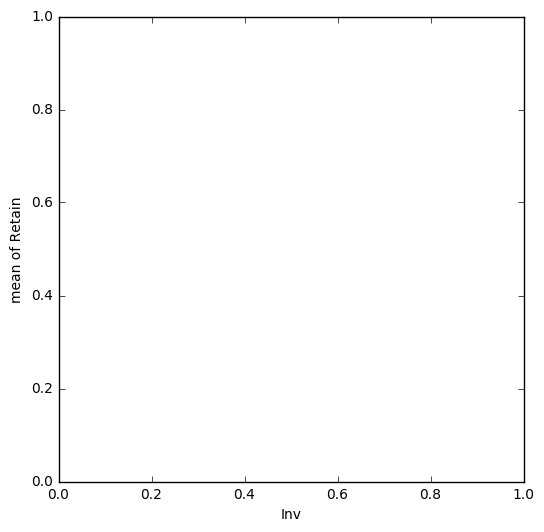

In [277]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(x=inter.Inv, trace=inter.TMT, response=inter.Retain,
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)